# Task 0

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This cell imports necessary libraries. Also, it contains a method that reads the logs and plots accordingly.

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import pathlib
import glob
from PIL import Image
from random import randint
import cv2
import numpy as np
import glob

def plot_logs(filename):
  hits1, hits3, hits10, mr, mrr, loss = [], [], [], [], [], []
  keywords = ["Valid HITS@1 ", "Valid HITS@3", "Valid HITS@10", "Valid MR ", "Valid MRR"]
  with open(filename) as f:
      lines = f.readlines()
  read_started = 0
  for line in lines:
    for keyw in keywords:    
      if line.find(keyw) != -1:
        line = line[line.find(keyw):]
        read_started += 1
        value = float(line[line.find(":")+1:].replace("\n", ""))
        if read_started == 1:
          mrr.append(value)
        if read_started == 2:
          mr.append(value)
        if read_started == 3:
          hits1.append(value)
        if read_started == 4:
          hits3.append(value)
        if read_started == 5:
          hits10.append(value)
          read_started = 0
      if line.find("average loss") != -1:
        line = line[line.find("average loss"):]
        value = float(line[line.find(":")+1:].replace("\n", ""))
        loss.append(value)

  fig, ax = plt.subplots(2,3, figsize = (16,8))
  ax[0][0].plot(loss)
  ax[0][0].set_title("Loss")

  ax[0][1].plot(mr)
  ax[0][1].set_title("mr")

  ax[0][2].plot(mrr)
  ax[0][2].set_title("mrr")
  ax[0][2].axis(ymin=0,ymax=1.1)

  ax[1][0].plot(hits1)
  ax[1][0].set_title("hits1")
  ax[1][0].axis(ymin=0,ymax=1.1)

  ax[1][1].plot(hits3)
  ax[1][1].set_title("hits3")
  ax[1][1].axis(ymin=0,ymax=1.1)

  ax[1][2].plot(hits10)
  ax[1][2].set_title("hits10")
  ax[1][2].axis(ymin=0,ymax=1.1)

  return hits1, hits3, hits10, mr, mrr, loss

Run below cell to copy the repository from github. Then dive into the directory

In [3]:
%cd /content/drive/MyDrive/AI_Labor
!rm -r /content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding
!git clone https://github.com/DeepGraphLearning/KnowledgeGraphEmbedding.git
%cd KnowledgeGraphEmbedding

/content/drive/MyDrive/AI_Labor
Cloning into 'KnowledgeGraphEmbedding'...
remote: Enumerating objects: 113, done.
remote: Total 113 (delta 0), reused 0 (delta 0), pack-reused 113
Receiving objects: 100% (113/113), 32.19 MiB | 14.60 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Checking out files: 100% (55/55), done.
/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding


Run below cell to remove redundant data

In [ ]:
# !rm -r /content/drive/MyDrive/KnowledgeGraphEmbedding/data/countries_S2
# !rm -r /content/KnowledgeGraphEmbedding/data/countries_S3

Run below cell to modify the code so that it is reproducible by setting numpy, torch and random's seed to a fixed value. Also it modifies the code a little bit to be able to save store embeddings during training



In [4]:
line ="torch.manual_seed(0)\nnp.random.seed(0)\n"
f = open("/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/codes/dataloader.py", "r")
contents = f.readlines()
f.close()
contents.insert(8, line)
f = open("/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/codes/dataloader.py", "w")
contents = "".join(contents)
f.write(contents)
f.close()

f = open("/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/codes/model.py", "r")
contents = f.readlines()
f.close()
contents.insert(13, line)
f = open("/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/codes/model.py", "w")
contents = "".join(contents)
f.write(contents)
f.close()

f = open("/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/codes/run.py", "r")
contents = f.readlines()
f.close()
contents.insert(14, line+"random.seed(0)")
f = open("/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/codes/run.py", "w")
contents = "".join(contents)
f.write(contents)
f.close()

f = open("/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/codes/run.py", "r")
contents = f.readlines()
f.close()
contents[91] = "def save_model(model, optimizer, save_variable_list, args, step=0):\n"
contents[110] = "        os.path.join(args.save_path, 'entity_embedding'+str(f\"{step:06d}\")), \n"
contents[325] = "                save_model(kge_model, optimizer, save_variable_list, args, step)\n"

f = open("/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/codes/run.py", "w")
contents = "".join(contents)
f.write(contents)
f.close()

Take a look at the data...

In [5]:
df_train = pd.read_csv("/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/data/yamanishi/train.txt", sep="\t", header=None)
headers =  ["head", "relation", "tail"]
df_train.columns = headers

print(df_train.sample(5))
print("\n\n\n")
print(df_train.describe())

            head     relation    tail
1870    hsa:8973  inhibitedBy  D00524
816   hsa:116443  inhibitedBy  D00711
1526     hsa:766  inhibitedBy  D00518
302     hsa:2321  inhibitedBy  D03252
1948     hsa:150  inhibitedBy  D02149




            head     relation    tail
count       1952         1952    1952
unique       303            1     200
top     hsa:6328  inhibitedBy  D00437
freq          21         1952      51


# Task 1

Training...

In [12]:
!CUDA_VISIBLE_DEVICES=0 python -u codes/run.py --do_train \
 --cuda \
 --do_valid \
 --do_test \
 --data_path data/yamanishi \
 --model RotatE \
 --valid_steps 500 \
 -n 20 -b 100 -d 100 \
 -g 6.0 -a 1.0 -adv \
-lr 0.05 --max_steps 5000 \
-save models/Task1_yamanishi_RotatE/g_6 --test_batch_size 16 -de

2022-09-15 14:26:26,718 INFO     Model: RotatE
2022-09-15 14:26:26,718 INFO     Data Path: data/yamanishi
2022-09-15 14:26:26,719 INFO     #entity: 510
2022-09-15 14:26:26,719 INFO     #relation: 1
2022-09-15 14:26:26,721 INFO     #train: 1952
2022-09-15 14:26:26,723 INFO     #valid: 651
2022-09-15 14:26:26,725 INFO     #test: 651
2022-09-15 14:26:26,727 INFO     Model Parameter Configuration:
2022-09-15 14:26:26,727 INFO     Parameter gamma: torch.Size([1]), require_grad = False
2022-09-15 14:26:26,727 INFO     Parameter embedding_range: torch.Size([1]), require_grad = False
2022-09-15 14:26:26,727 INFO     Parameter entity_embedding: torch.Size([510, 200]), require_grad = True
2022-09-15 14:26:26,728 INFO     Parameter relation_embedding: torch.Size([1, 100]), require_grad = True
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, whi

Plots of training

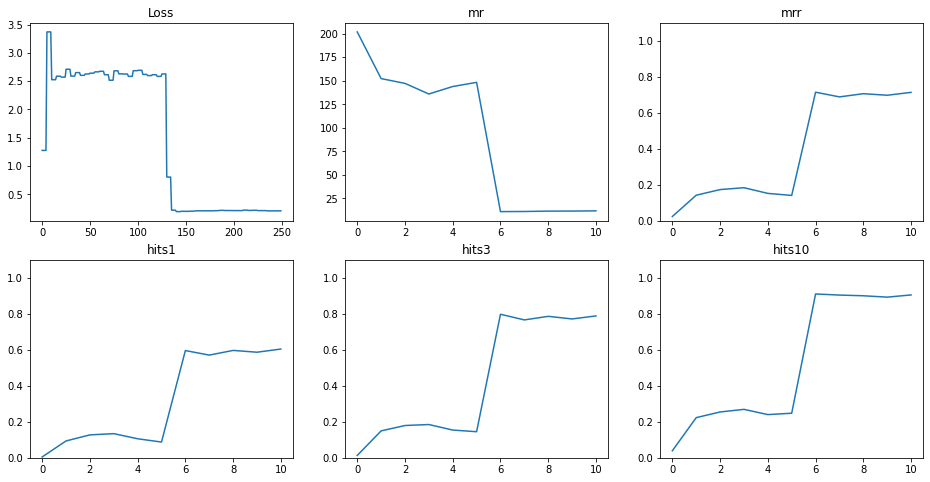

In [13]:
hits1, hits3, hits10, mr, mrr, loss = plot_logs('/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/models/Task1_yamanishi_RotatE/g_6/train.log')

Below cell makes embeddings saveable and displays it

In [14]:
ent_embeddings = np.load("/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/models/Task1_yamanishi_RotatE/g_6/entity_embedding000000.npy")
dim_size = ent_embeddings.shape[1]

headers = []
for x in range(dim_size):
  headers.append("d"+str(x))

ent_names = []
for line in open("/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/data/yamanishi/entities.dict"):
  ent_names.append(line.split("\t")[1][:-1])

df_ent_embeddings = pd.DataFrame(data=ent_embeddings, index=ent_names, columns=headers)
df_ent_embeddings.sample(5)

,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d190,d191,d192,d193,d194,d195,d196,d197,d198,d199
hsa:767,0.063468,-0.034929,-0.093387,-0.181481,0.001199,-0.053235,-0.134530,-0.037422,-0.077385,0.054938,...,0.116095,-0.009829,-0.044156,-0.008344,0.097838,0.021964,-0.048979,0.022516,0.046786,0.025602
D00740,-0.044008,0.043057,0.088257,0.052618,-0.030160,-0.087788,0.017231,-0.020174,0.026445,0.026680,...,0.022756,0.040084,0.009906,-0.007725,-0.013879,0.043794,0.065451,-0.078755,-0.015825,0.008517
D00252,-0.040551,0.073025,0.108790,0.059334,-0.006583,-0.076976,-0.048044,-0.014790,-0.002697,-0.018038,...,0.051840,0.040960,0.032654,0.000914,-0.022221,0.003219,-0.052974,-0.076875,-0.037233,-0.067892
hsa:2555,0.033860,0.090758,-0.061966,0.008948,-0.035981,0.021058,0.061989,-0.095775,-0.054350,0.022612,...,0.021113,-0.035839,0.118392,-0.020469,-0.045899,0.039599,0.055660,0.013378,-0.110251,0.007168
D00499,0.071101,0.055176,0.090620,-0.035363,-0.036841,-0.057214,0.012917,0.028280,0.061452,0.067585,...,-0.058517,0.020915,-0.099553,-0.011493,0.039482,0.082968,-0.080759,-0.020617,0.020756,-0.050457


Below cell saves the embeddings

In [15]:
df_ent_embeddings.to_csv("/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/models/Task1_yamanishi_RotatE/g_6/task1_labeled_embeddings.tsv", sep="\t",index=True, header=True)
df_ent_embeddings.to_csv("/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/models/Task1_yamanishi_RotatE/g_6/task1_embeddings.tsv", sep="\t",index=False, header=False)

In [18]:
!CUDA_VISIBLE_DEVICES=0 python -u codes/run.py --do_train \
 --do_valid \
 --do_test \
 --data_path data/yamanishi \
 --model TransE \
 --valid_steps 50 \
 -n 20 -b 100 -d 100 \
 -g 6.0 -a 1.0 -adv \
-lr 0.05 --max_steps 5000 \
-save models/Task2_yamanishi_TransE --test_batch_size 16

2022-09-15 14:33:23,001 INFO     Model: TransE
2022-09-15 14:33:23,002 INFO     Data Path: data/yamanishi
2022-09-15 14:33:23,002 INFO     #entity: 510
2022-09-15 14:33:23,002 INFO     #relation: 1
2022-09-15 14:33:23,004 INFO     #train: 1952
2022-09-15 14:33:23,006 INFO     #valid: 651
2022-09-15 14:33:23,008 INFO     #test: 651
2022-09-15 14:33:23,009 INFO     Model Parameter Configuration:
2022-09-15 14:33:23,009 INFO     Parameter gamma: torch.Size([1]), require_grad = False
2022-09-15 14:33:23,010 INFO     Parameter embedding_range: torch.Size([1]), require_grad = False
2022-09-15 14:33:23,010 INFO     Parameter entity_embedding: torch.Size([510, 100]), require_grad = True
2022-09-15 14:33:23,010 INFO     Parameter relation_embedding: torch.Size([1, 100]), require_grad = True
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, whi

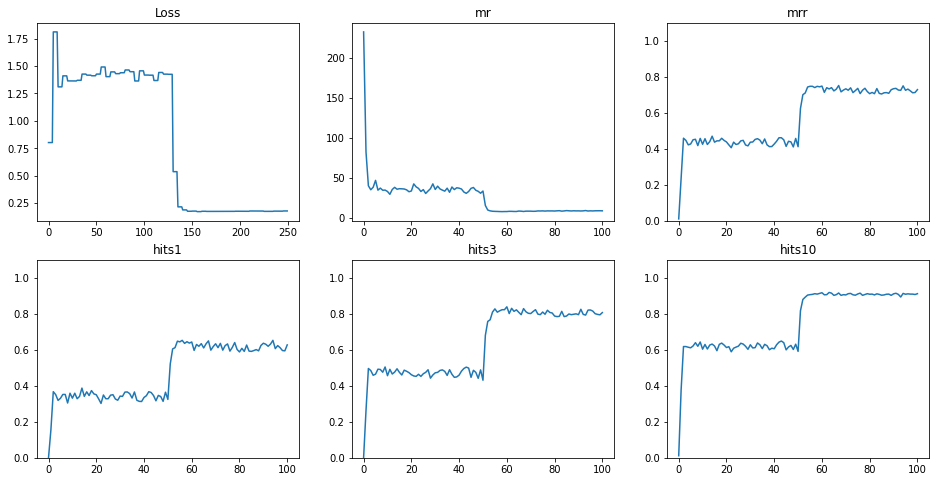

In [19]:
hits1, hits3, hits10, mr, mrr, loss = plot_logs('/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/models/Task2_yamanishi_TransE/train.log')

# Task 2

This cell copies the original data into a safe spot. This is important because we will change the data

In [7]:
#run this cell to copy the original data into a safe file
!cp /content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/data/yamanishi/train.txt /content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/data/yamanishi/original_train.txt
!cp /content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/data/yamanishi/valid.txt /content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/data/yamanishi/original_valid.txt
!cp /content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/data/yamanishi/test.txt /content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/data/yamanishi/original_test.txt

Below cell restores the original data. Run this cell whenever you want to restore the original data

In [ ]:
#run this cell to restore the original train-valid set of countries_S1
!rm /content/KnowledgeGraphEmbedding/data/countries_S1/train.txt
!rm /content/KnowledgeGraphEmbedding/data/countries_S1/valid.txt
!rm /content/KnowledgeGraphEmbedding/data/countries_S1/test.txt

!cp /content/KnowledgeGraphEmbedding/data/countries_S1/original_train.txt /content/KnowledgeGraphEmbedding/data/countries_S1/train.txt
!cp /content/KnowledgeGraphEmbedding/data/countries_S1/original_valid.txt /content/KnowledgeGraphEmbedding/data/countries_S1/valid.txt
!cp /content/KnowledgeGraphEmbedding/data/countries_S1/original_test.txt /content/KnowledgeGraphEmbedding/data/countries_S1/test.txt

Take a look at the resulting data...

In [8]:
df = pd.read_csv("/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/data/yamanishi/train.txt", sep="\t", header=None)

print(df.sample(5))
print("\n\n\n")
print(df.describe())

            0              1         2
3376   D01911       inhibits  hsa:7153
3079  DB01201  interactsWith   DB00624
453   DB00788       inhibits   hsa:242
255    D00293       inhibits  hsa:2563
5040   D03826       inhibits  hsa:1135




              0              1        2
count      5525           5525     5525
unique      942              2      332
top     DB01115  interactsWith  DB00783
freq         58           3466      428


Training...

In [9]:
!CUDA_VISIBLE_DEVICES=0 python -u codes/run.py --do_train \
 --do_valid \
 --do_test \
 --data_path data/yamanishi \
 --model RotatE \
 --valid_steps 10 \
 -n 5 -b 20 -d 10 \
 -g 6.0 -a 1.0 -adv \
-lr 0.05 --max_steps 500 \
-save models/Task2_yamanishi_RotatE --test_batch_size 16 -de

2022-09-15 07:33:30,324 INFO     Model: RotatE
2022-09-15 07:33:30,325 INFO     Data Path: data/yamanishi
2022-09-15 07:33:30,325 INFO     #entity: 1254
2022-09-15 07:33:30,325 INFO     #relation: 2
2022-09-15 07:33:30,332 INFO     #train: 5525
2022-09-15 07:33:30,335 INFO     #valid: 1829
2022-09-15 07:33:30,337 INFO     #test: 1832
2022-09-15 07:33:30,339 INFO     Model Parameter Configuration:
2022-09-15 07:33:30,339 INFO     Parameter gamma: torch.Size([1]), require_grad = False
2022-09-15 07:33:30,339 INFO     Parameter embedding_range: torch.Size([1]), require_grad = False
2022-09-15 07:33:30,339 INFO     Parameter entity_embedding: torch.Size([1254, 20]), require_grad = True
2022-09-15 07:33:30,339 INFO     Parameter relation_embedding: torch.Size([2, 10]), require_grad = True
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, w

Plotting...

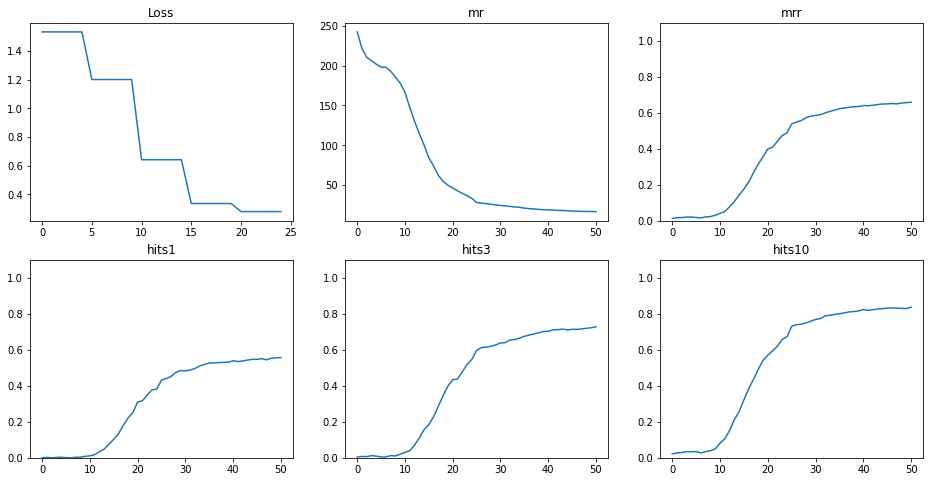

In [ ]:
hits1, hits3, hits10, mr, mrr, loss = plot_logs('/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/models/Task2_yamanishi_RotatE/train.log')

Training...

In [18]:
!CUDA_VISIBLE_DEVICES=0 python -u codes/run.py --do_train \
 --do_valid \
 --do_test \
 --data_path data/yamanishi \
 --model TransE \
 --valid_steps 50 \
 -n 5 -b 20 -d 20 \
 -g 6.0 -a 1.0 -adv \
-lr 0.05 --max_steps 1500 \
-save models/Task2_yamanishi_TransE --test_batch_size 16

2022-09-15 08:07:09,199 INFO     Model: TransE
2022-09-15 08:07:09,199 INFO     Data Path: data/yamanishi
2022-09-15 08:07:09,199 INFO     #entity: 1254
2022-09-15 08:07:09,199 INFO     #relation: 2
2022-09-15 08:07:09,205 INFO     #train: 5525
2022-09-15 08:07:09,208 INFO     #valid: 1829
2022-09-15 08:07:09,210 INFO     #test: 1832
2022-09-15 08:07:09,212 INFO     Model Parameter Configuration:
2022-09-15 08:07:09,212 INFO     Parameter gamma: torch.Size([1]), require_grad = False
2022-09-15 08:07:09,212 INFO     Parameter embedding_range: torch.Size([1]), require_grad = False
2022-09-15 08:07:09,212 INFO     Parameter entity_embedding: torch.Size([1254, 20]), require_grad = True
2022-09-15 08:07:09,213 INFO     Parameter relation_embedding: torch.Size([2, 20]), require_grad = True
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, w

Plotting...

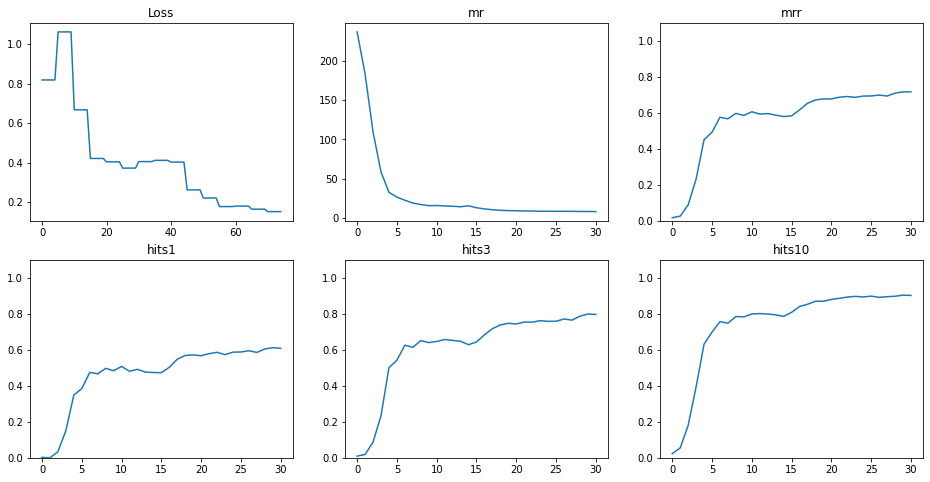

In [ ]:
hits1, hits3, hits10, mr, mrr, loss = plot_logs('/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/models/Task2_yamanishi_TransE/train.log')

Below cell reads the embeddings (both entities and relations). After that, it shows the absolute value of each model's relation embeddings. Observe how TransE has lower value that goes towards 0!

---RELS of RotatE
Rels
0.41386208
---RELS of TransE
Rels
0.47817144


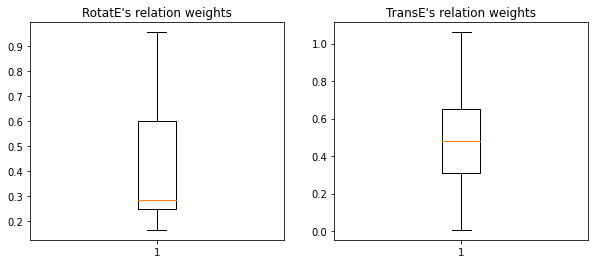

In [ ]:
rels_rotate = np.load("/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/models/Task2_yamanishi_RotatE/relation_embedding.npy")
ents_rotate = np.load("/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/models/Task2_yamanishi_RotatE/entity_embedding000000.npy")

rels_transe = np.load("/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/models/Task2_yamanishi_TransE/relation_embedding.npy")
ents_transe = np.load("/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/models/Task2_yamanishi_TransE/entity_embedding000000.npy")

fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].boxplot(np.abs(rels_rotate[0]))
ax[0].set_title("RotatE's relation weights")
ax[1].boxplot(np.abs(rels_transe[0]))
ax[1].set_title("TransE's relation weights")

print("---RELS of RotatE")
print("Rels")
print(np.abs(rels_rotate[0]).mean())

print("---RELS of TransE")
print("Rels")
print(np.abs(rels_transe[0]).mean())

dim_size = ents_rotate.shape[1]
ent_size = ents_rotate.shape[0]

Below cell prepares the data as saveable and saves it for visualization purposes

In [ ]:
df.columns = ["head", "relation", "tail"]
headers = []
for x in range(dim_size):
  headers.append("d"+str(x))

#fetching indices of used entities: 
tmp = pd.read_csv("/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/data/yamanishi/entities.dict", sep="\t", header=None)
tmp.columns = ["key", "value"]
tmp_filtered = tmp["value"].isin(list(set(df['head'].values)))
filtered_entities = tmp[tmp_filtered]
indices_of_used_entities = filtered_entities['key'].values
names_of_used_entities = filtered_entities['value'].values

rotate_filtered_entites = np.take(ents_rotate, indices_of_used_entities, axis=0)
df_rotate = pd.DataFrame(data=rotate_filtered_entites, index=names_of_used_entities, columns=headers)
transe_filtered_entites = np.take(ents_transe, indices_of_used_entities, axis=0)
df_transe = pd.DataFrame(data=transe_filtered_entites, index=names_of_used_entities, columns=headers)

df_transe.to_csv("transe_labeled_embeddings.tsv", sep="\t",index=True, header=True)
df_transe.to_csv("transe_embeddings.tsv", sep="\t",index=False, header=False)
df_rotate.to_csv("rotate_labeled_embeddings.tsv", sep="\t",index=True, header=True)
df_rotate.to_csv("rotate_embeddings.tsv", sep="\t",index=False, header=False)

# Task 3

Restore the original data back

In [ ]:
#run this cell to copy the original data into a safe file
!cp /content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/data/yamanishi/train.txt /content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/data/yamanishi/original_train.txt
!cp /content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/data/yamanishi/valid.txt /content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/data/yamanishi/original_valid.txt
!cp /content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/data/yamanishi/test.txt /content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/data/yamanishi/original_test.txt

In [ ]:
#run this cell to restore the original train-valid set of countries_S1
!rm /content/KnowledgeGraphEmbedding/data/countries_S1/train.txt
!rm /content/KnowledgeGraphEmbedding/data/countries_S1/valid.txt
!rm /content/KnowledgeGraphEmbedding/data/countries_S1/test.txt

!cp /content/KnowledgeGraphEmbedding/data/countries_S1/original_train.txt /content/KnowledgeGraphEmbedding/data/countries_S1/train.txt
!cp /content/KnowledgeGraphEmbedding/data/countries_S1/original_valid.txt /content/KnowledgeGraphEmbedding/data/countries_S1/valid.txt
!cp /content/KnowledgeGraphEmbedding/data/countries_S1/original_test.txt /content/KnowledgeGraphEmbedding/data/countries_S1/test.txt

Take a look at data...

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/data/yamanishi/train.txt", sep="\t", header=None)

print(df)
print("\n\n\n")
print(df.describe())

              0            1       2
0      hsa:5147  inhibitedBy  D00528
1       hsa:147  inhibitedBy  D00454
2      hsa:2562  inhibitedBy  D00548
3      hsa:6340  inhibitedBy  D00552
4      hsa:1562  inhibitedBy  D01425
...         ...          ...     ...
1947    hsa:147  inhibitedBy  D00437
1948    hsa:150  inhibitedBy  D02149
1949    hsa:773  inhibitedBy  D02914
1950   hsa:5141  inhibitedBy  D01198
1951  hsa:93589  inhibitedBy  D00512

[1952 rows x 3 columns]




               0            1       2
count       1952         1952    1952
unique       303            1     200
top     hsa:6328  inhibitedBy  D00437
freq          21         1952      51


Below cell deletes all the saved embeddings under Task3's folder. Also, it deletes the produced plots and thus resets the folders for experimenting again!

In [ ]:
!find /content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/models/Task3_yamanishi_2Dim -type f -name '*entity_embedding*' -delete
!rm -r /content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/models/Task3_yamanishi_2Dim/plots/

Training... In the meantime below code takes snapshots of embeddings (saves each embedding state at every i'th epoch). If one wants to increase the frequency of the snapshots, one can do so via "save_checkpoint_steps"



In [ ]:
# !CUDA_VISIBLE_DEVICES=0 python -u codes/run.py --do_train \
#  --do_valid \
#  --do_test \
#  --data_path data/yamanishi \
#  --model TransE \
#  --valid_steps 50 \
#  --save_checkpoint_steps 2 \
#  -n 10 -b 20 -d 2 \
#  -g 2.0 -a 1.0 -adv \
# -lr 0.1 --max_steps 250 \
# -save models/Task3_yamanishi_2Dim --test_batch_size 16 

2022-08-25 08:18:07,273 INFO     Model: RotatE
2022-08-25 08:18:07,274 INFO     Data Path: data/yamanishi
2022-08-25 08:18:07,274 INFO     #entity: 510
2022-08-25 08:18:07,274 INFO     #relation: 1
2022-08-25 08:18:07,276 INFO     #train: 1952
2022-08-25 08:18:07,278 INFO     #valid: 648
2022-08-25 08:18:07,280 INFO     #test: 635
2022-08-25 08:18:07,280 INFO     Model Parameter Configuration:
2022-08-25 08:18:07,281 INFO     Parameter gamma: torch.Size([1]), require_grad = False
2022-08-25 08:18:07,281 INFO     Parameter embedding_range: torch.Size([1]), require_grad = False
2022-08-25 08:18:07,281 INFO     Parameter entity_embedding: torch.Size([510, 4]), require_grad = True
2022-08-25 08:18:07,281 INFO     Parameter relation_embedding: torch.Size([1, 2]), require_grad = True
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which i

In [ ]:
!CUDA_VISIBLE_DEVICES=0 python -u codes/run.py --do_train \
 --do_valid \
 --do_test \
 --data_path data/yamanishi \
 --model DistMult \
 --valid_steps 50 \
 --save_checkpoint_steps 2 \
 -n 10 -b 20 -d 2 \
 -g 2.0 -a 1.0 -adv \
-lr 0.1 --max_steps 250 \
-save models/Task3_yamanishi_2Dim --test_batch_size 16

2022-08-25 08:37:36,916 INFO     Model: DistMult
2022-08-25 08:37:36,916 INFO     Data Path: data/yamanishi
2022-08-25 08:37:36,916 INFO     #entity: 510
2022-08-25 08:37:36,917 INFO     #relation: 1
2022-08-25 08:37:36,919 INFO     #train: 1952
2022-08-25 08:37:36,922 INFO     #valid: 648
2022-08-25 08:37:36,924 INFO     #test: 635
2022-08-25 08:37:36,925 INFO     Model Parameter Configuration:
2022-08-25 08:37:36,925 INFO     Parameter gamma: torch.Size([1]), require_grad = False
2022-08-25 08:37:36,925 INFO     Parameter embedding_range: torch.Size([1]), require_grad = False
2022-08-25 08:37:36,925 INFO     Parameter entity_embedding: torch.Size([510, 2]), require_grad = True
2022-08-25 08:37:36,926 INFO     Parameter relation_embedding: torch.Size([1, 2]), require_grad = True
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which

Read out the snapshotted embeddings

In [ ]:
embedding_history_paths = sorted(list(pathlib.Path('/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/models/Task3_yamanishi_2Dim').glob('*.npy')))
history = []

for i in range (len(embedding_history_paths)):
  if "entity" in str(embedding_history_paths[i]):
    emb = np.load(embedding_history_paths[i])

    headers = []
    dim_size = emb.shape[1]
    for x in range(dim_size):
      headers.append("d"+str(x))

    #fetching indices of used entities: 
    tmp = pd.read_csv("/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/data/yamanishi/entities.dict", sep="\t", header=None)
    tmp.columns = ["key", "value"]
    tmp_filtered = tmp["value"].isin(set(np.concatenate((df[0].values, df[2].values))))
    filtered_entities = tmp[tmp_filtered]
    indices_of_used_entities = filtered_entities['key'].values
    names_of_used_entities = filtered_entities['value'].values
    transe_historical_embeddings = np.take(emb, indices_of_used_entities, axis=0)
    df_transe_historical_embeddings = pd.DataFrame(data=transe_historical_embeddings, index=names_of_used_entities, columns=headers)
    history.append(df_transe_historical_embeddings)


Create necessary directories for experiment outputs

In [ ]:
%mkdir /content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/models/Task3_yamanishi_2Dim/plots/
%mkdir /content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/models/Task3_yamanishi_2Dim/gif/
%mkdir /content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/models/Task3_yamanishi_2Dim/video/

mkdir: cannot create directory ‘/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/models/Task3_yamanishi_2Dim/plots/’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/models/Task3_yamanishi_2Dim/gif/’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/models/Task3_yamanishi_2Dim/video/’: File exists


Create plots (each plot represents the geometric location of entities in the geometric space. Since the dimensions were 2, we see the embeddings as they are! (rather an extra postprocessing layer of dimensionality reduction technique!)

In [ ]:
colors = []
for i in range(len(history[1].index)):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

xCoor = []
yCoor = []
for i in range (len(history)):
  xCoor.append(history[i]["d0"].values)
  yCoor.append(history[i]["d1"].values)

for i in range(len(history)):
  fig, ax = plt.subplots(figsize=(10,10))
  ax.scatter(xCoor[i], yCoor[i], c=colors, s=150)
  ax.set_title("Snapshot: "+ str(i))
  for j, txt in enumerate(list(history[0].index)):
    ax.annotate(txt, (xCoor[i][j], yCoor[i][j]))
  if i % 5 == 0:
    print("Figure " + str(i) + " is ready!...")
  fig.savefig("/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/models/Task3_yamanishi_2Dim/plots/fig_"+str(f"{i:04d}")+".png")
  fig.clf()

Figure 0 is ready!...
Figure 5 is ready!...
Figure 10 is ready!...
Figure 15 is ready!...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


Figure 20 is ready!...
Figure 25 is ready!...
Figure 30 is ready!...
Figure 35 is ready!...
Figure 40 is ready!...
Figure 45 is ready!...
Figure 50 is ready!...
Figure 55 is ready!...
Figure 60 is ready!...
Figure 65 is ready!...
Figure 70 is ready!...
Figure 75 is ready!...
Figure 80 is ready!...
Figure 85 is ready!...
Figure 90 is ready!...
Figure 95 is ready!...
Figure 100 is ready!...
Figure 105 is ready!...
Figure 110 is ready!...
Figure 115 is ready!...
Figure 120 is ready!...


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

Below cell creates a GIF out of the snapshots

In [ ]:
fp_in = "/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/models/Task3_yamanishi_2Dim/plots/*"
fp_out = "/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/models/Task3_yamanishi_2Dim/gif/task3.gif"

img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in)[1:])]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=300, loop=0)

Below cell creates a video out of the snapshots

In [ ]:
img_array = []
for filename in sorted(glob.glob(fp_in))[1:]:
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
 
out = cv2.VideoWriter('/content/drive/MyDrive/AI_Labor/KnowledgeGraphEmbedding/models/Task3_yamanishi_2Dim/video/task3.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [ ]:
'''
for transE
!CUDA_VISIBLE_DEVICES=0 python -u codes/run.py --do_train \
 --do_valid \
 --do_test \
 --data_path data/countries_S1 \
 --model TransE \
 --valid_steps 50 \
 --save_checkpoint_steps 10 \
 -n 5 -b 20 -d 2 \
 -g 4.0 -a 1.0 -adv \
-lr 0.1 --max_steps 1000 \
-save models/Task3_Countries_2Dim --test_batch_size 16

for distmult
!CUDA_VISIBLE_DEVICES=0 python -u codes/run.py --do_train \
 --do_valid \
 --do_test \
 --data_path data/countries_S1 \
 --model DistMult \
 --valid_steps 50 \
 --save_checkpoint_steps 2 \
 -n 10 -b 20 -d 2 \
 -g 2.0 -a 1.0 -adv \
-lr 0.1 --max_steps 250 \
-save models/Task3_Countries_2Dim --test_batch_size 16

for Rotate
!CUDA_VISIBLE_DEVICES=0 python -u codes/run.py --do_train \
 --do_valid \
 --do_test \
 --data_path data/countries_S1 \
 --model DistMult \
 --valid_steps 50 \
 --save_checkpoint_steps 2 \
 -n 10 -b 20 -d 2 \
 -g 2.0 -a 1.0 -adv \
-lr 0.1 --max_steps 250 \
-save models/Task3_Countries_2Dim --test_batch_size 16
'''

'\nfor transE\n!CUDA_VISIBLE_DEVICES=0 python -u codes/run.py --do_train  --do_valid  --do_test  --data_path data/countries_S1  --model TransE  --valid_steps 50  --save_checkpoint_steps 10  -n 5 -b 20 -d 2  -g 4.0 -a 1.0 -adv -lr 0.1 --max_steps 1000 -save models/Task3_Countries_2Dim --test_batch_size 16\n\nfor distmult\n\n'